<a href="https://colab.research.google.com/github/tw159376/experiments/blob/main/Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Cython
!pip install Ripser

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.3 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=f073dba94aef78bf5dca68fb8cf9df49af432c5494e09002334228e52c89d4cc
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [2]:
from sklearn.metrics import mutual_info_score
from statsmodels.stats.dist_dependence_measures import distance_correlation
from ripser import ripser
from persim import plot_diagrams
from scipy.integrate import solve_ivp
from scipy.signal import argrelmin
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.gridspec as gridspec

In [3]:
def mutual_information(X, Y, n_bins):
    contingency = np.histogram2d(X, Y, bins=n_bins)[0]
    mutual_information = mutual_info_score(None, None, contingency=contingency)
    return mutual_information

In [4]:
def _mutual_information(X, max_lag, n_bins):
  cors = []
  for lag in range(max_lag):
    c = 0
    if lag==0:
      cors.append(mutual_information(X, X, n_bins))
    else:
      cors.append(mutual_information(X[:-lag], X[lag:], n_bins))
  return cors

def _distance_correlation(X, max_lag):
  cors = []
  for lag in range(max_lag):
    c = 0
    if lag==0:
      cors.append(distance_correlation(X, X))
    else:
      cors.append(distance_correlation(X[:-lag], X[lag:]))
  return cors

In [5]:
def create_embedding(lag, dimension, X):
  return np.array([[X[i+j*lag] for j in range(dimension)] for i in range(len(X)-(dimension-1)*lag)])

In [6]:
def calculate_persistence(X):
  H1 = ripser(X)['dgms'][1]
  if len(H1) == 0:
      return None
  return float(max(H1, key=lambda x: x[1] - x[0])[1])

In [7]:
def plot_time_series(data, title='Time Series Plot', xlabel='Time', ylabel='Value', filename="file.png"):

    plt.figure(figsize=(10, 5))
    plt.plot(data[len(data)//2][0], linestyle='-', color='r', label="with noise")
    plt.plot(data[0][0], linestyle='-', color='b', label="no noise")
    #plt.plot(data[len(data)//2][0], linestyle='-', color='r', label="with noise")
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()


    fig = plt.gcf()
    target_width = 5.7
    # Get current figure size
    current_width, current_height = fig.get_size_inches()
    # Compute new height to preserve aspect ratio
    aspect_ratio = current_height / current_width
    new_height = target_width * aspect_ratio
    # Set the new size
    fig.set_size_inches(target_width, new_height)
    # Save at high DPI
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

In [8]:
def plot_correlation(corr_mis, corr_dcs, min_corr_mis, min_corr_dcs, filename="file.png"):
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
  m = len(corr_mis)//2
  for i in range(2):
    ax = [ax1, ax2][i]
    corr_mi = corr_mis[0] if i == 0 else corr_mis[m]
    corr_dc = corr_dcs[0] if i == 0 else corr_dcs[m]
    min_corr_mi = min_corr_mis[0] if i == 0 else min_corr_mis[m]
    min_corr_dc = min_corr_dcs[0] if i == 0 else min_corr_dcs[m]
    ax.plot(
          range(len(corr_mi)),
          corr_mi,
          label='Mutual Information',
          color='blue',      # mutual information in blue
          marker='o',
          linestyle='-'
      )
    ax.plot(
        range(len(corr_dc)),
        corr_dc,
        label='Distance Correlation',
        color='green',     # distance correlation in green
        marker='o',
        linestyle='-'
    )

    ax.axvline(x=min_corr_mi, color='blue', linestyle='--', label='First Local Min')
    ax.axvline(x=min_corr_dc, color='green', linestyle='--', label='First Local Min')

    ax.set_xlabel('Time Lag')
    ax.set_ylabel('Correlation')
    ax.set_title('No Noise' if i==0 else "With Noise")
    ax.legend()
  plt.tight_layout()
  plt.subplots_adjust(hspace=0.6)
  target_width = 5.7
  # Get current figure size
  current_width, current_height = fig.get_size_inches()
  # Compute new height to preserve aspect ratio
  aspect_ratio = current_height / current_width
  new_height = target_width * aspect_ratio
  # Set the new size
  fig.set_size_inches(target_width, new_height)
  # Save at high DPI
  plt.savefig(filename, dpi=300, bbox_inches='tight')
  plt.show()

In [9]:
def plot_embedding(statespace, embedding_mis, embedding_dcs, dim, filename="file.png"):
    fig = plt.figure(figsize=(12,18))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

    ax0 = fig.add_subplot(gs[0, :], projection='3d' if dim == 3 else None)
    if dim == 2:
        ax0.plot(statespace[:, 0], statespace[:, 1], marker='o', markersize=3, linestyle='-', color='red', linewidth=0.5)
        ax0.set_xlabel("X")
        ax0.set_ylabel("Y")
    else:
        ax0.plot(statespace[:, 0], statespace[:, 1], statespace[:, 2], marker='o', markersize=3, linestyle='-', color='red', linewidth=0.5)
        ax0.set_xlabel("X")
        ax0.set_ylabel("Y")
        ax0.set_zlabel("Z")
    ax0.set_title("State Space")
    ax0.set_aspect('equal')

    for i in range(2):
      for j in range(2):
        ax = fig.add_subplot(gs[i+1, j], projection='3d' if dim == 3 else None)
        ind = 0 if i==0 else len(embedding_mis)//2
        embedding = embedding_mis[ind] if j==0 else embedding_dcs[ind]
        color = 'blue' if j==0 else 'green'
        if dim == 2:
            ax.plot(embedding[:, 0], embedding[:, 1], marker='o', markersize=1, linestyle='-', color=color, linewidth=0.5)
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
        else:
            ax.plot(embedding[:, 0], embedding[:, 1], embedding[:, 2], marker='o', markersize=1, linestyle='-', color=color, linewidth=0.5)
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
            ax.set_zlabel("Z")
        titles = [["Mutual Information", "Distance Correlation"], ["Mutual Information (Noise)", "Distance Correlation (Noise)"]]
        ax.set_title(titles[i][j])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.35, hspace=0.35)

    fig = plt.gcf()
    target_width = 5.7
    # Get current figure size
    current_width, current_height = fig.get_size_inches()
    # Compute new height to preserve aspect ratio
    aspect_ratio = current_height / current_width
    new_height = target_width * aspect_ratio
    # Set the new size
    fig.set_size_inches(target_width, new_height)
    # Save at high DPI
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [33]:
def calculate_persistence(X):
  H1 = ripser(X)['dgms'][1]
  if len(H1) == 0:
    return None
  return float(max(map(lambda x: x[1]-x[0], H1)))

def plot_persistence(noise_lst, min_corr_mis, embedding_mis, min_corr_dcs, embedding_dcs, filename="file.png"):
  data = [
      [np.round(noise_lst[i],3),
       int(min_corr_mis[i]),
       np.round(calculate_persistence(embedding_mis[i]),3),
       int(min_corr_dcs[i]),
       np.round(calculate_persistence(embedding_dcs[i]),3)
      ] for i in range(len(noise_lst))
  ]
  columns = [
    "Noise SD",
    "MI: Location of \n First Local Min",
    "MI: MSDV of \n Embedding",
    "DC: Location of \n First Local Min",
    "DC: MSDV of \n Embedding"
]

  # Create a figure and turn off the axes
  fig =  plt.figure(figsize=(5.7,5.7*0.75))
  ax = fig.add_axes([0, 0, 1, 1])
  ax.axis('off')  # Hide the plot axes

  # Create the table
  table = ax.table(cellText=data, colLabels=columns, loc='center')

  #table.auto_set_column_width(col=list(range(len(columns))))
  bbox = table.get_window_extent(fig.canvas.get_renderer())
  table.auto_set_font_size(False)
  table.set_fontsize(8)
  for (row, col), cell in table.get_celld().items():
      cell.set_width(0.17)
      cell.set_height(0.07)
      if row == 0:
          cell.set_height(0.1)
          cell.set_fontsize(7)
          cell.set_text_props(weight='bold')
          cell.set_facecolor('#D3D3D3')  # Light gray
  # dpi = fig.dpi
  # fig_width_px, fig_height_px = fig.get_size_inches() * dpi

  # bbox_table = table.get_window_extent(fig.canvas.get_renderer())
  # # Calculate ratios
  # width_ratio = fig_width_px / bbox_table.width
  # height_ratio = fig_height_px / bbox_table.height

  # table.scale(width_ratio, height_ratio)
  plt.savefig(filename, dpi=300, bbox_inches='tight')
  plt.show()

In [34]:
def plots(statespace, X, name, dimension, max_lag, n_bins, order):
  noise_lst = np.linspace(0,1,11) * np.max(X)
  Xs = [(X+np.random.normal(0,noise,len(X)), noise) for noise in noise_lst]
  plot_time_series(Xs,filename=f"{name}_series.png")

  corr_mis = [_mutual_information(X[0], max_lag, n_bins) for X in Xs]
  corr_dcs = [_distance_correlation(X[0], max_lag) for X in Xs]

  min_corr_mis =[int(argrelmin(np.array(corr_mi), order=order)[0][0]) for corr_mi in corr_mis]
  min_corr_dcs =[int(argrelmin(np.array(corr_dc), order=order)[0][0]) for corr_dc in corr_dcs]

  embedding_mis = [create_embedding(min_corr_mis[i], dimension, Xs[i][0]) for i in range(len(Xs))]
  embedding_dcs = [create_embedding(min_corr_dcs[i], dimension, Xs[i][0]) for i in range(len(Xs))]

  plot_correlation(corr_mis, corr_dcs, min_corr_mis, min_corr_dcs, filename=f"{name}_correlation.png")
  plot_embedding(statespace, embedding_mis, embedding_dcs, dimension, filename=f"{name}_embedding.png")
  plot_persistence(noise_lst, min_corr_mis, embedding_mis, min_corr_dcs, embedding_dcs, filename=f"{name}_persistence.png")

# Sine Curve

In [35]:
t = np.linspace(0,12*np.pi,500)
X = np.cos(t)
Y = np.sin(t)
statespace = np.stack((X, Y), axis=1)

n_bins = int(math.sqrt(len(X)))
dimension = 2
max_lag = 50
order = 1

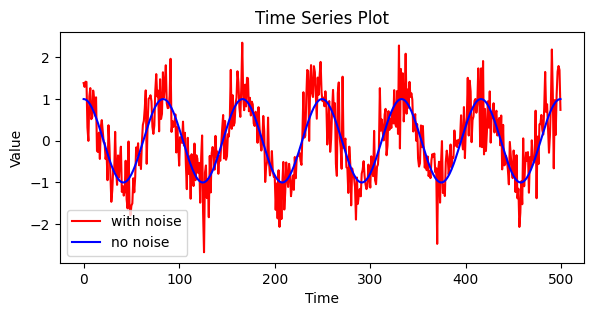

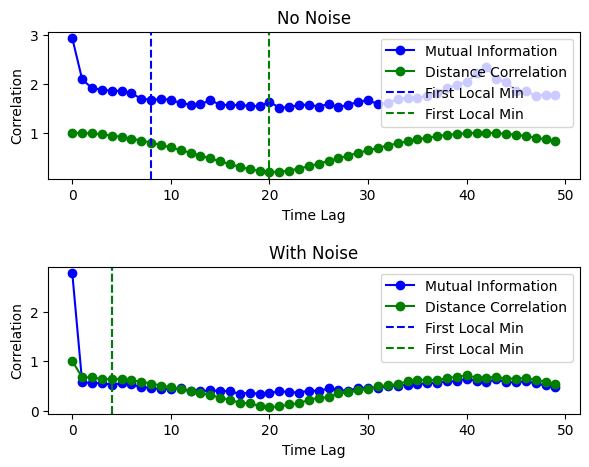

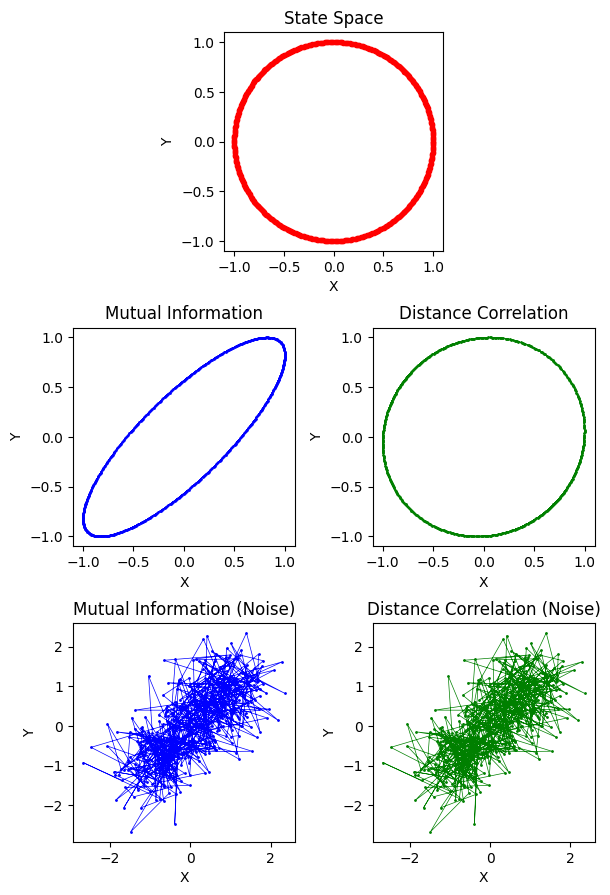

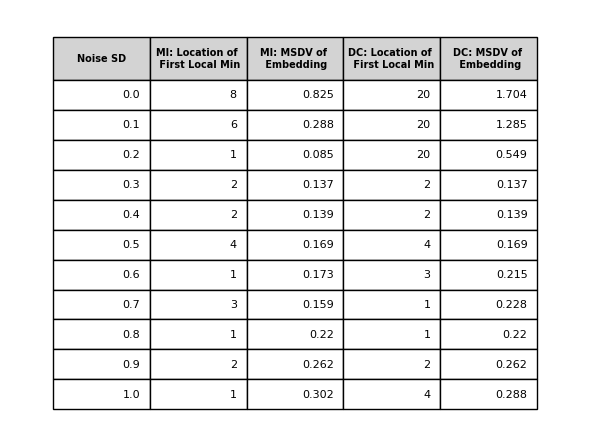

In [36]:
plots(statespace, X,"sine", dimension, max_lag, n_bins, order)

# Torus

In [37]:
t = np.linspace(0,50*np.pi,500)
X = (1.5-0.4*np.cos(np.sqrt(2)*t))*np.cos(t)
Y = (1.5-0.4*np.cos(np.sqrt(2)*t))*np.sin(t)
Z = 0.4*np.sin(np.sqrt(2)*t)
statespace = np.stack((X, Y, Z), axis=1)

n_bins = int(math.sqrt(len(X)))
dimension = 3
max_lag = 50
order = 1

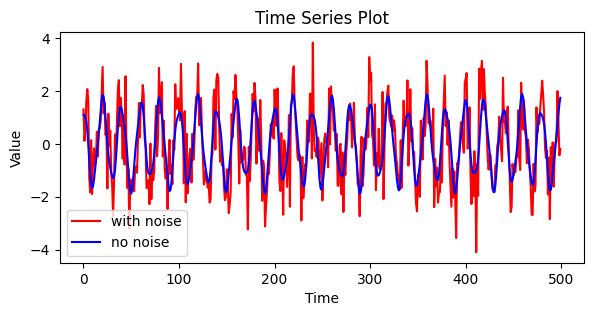

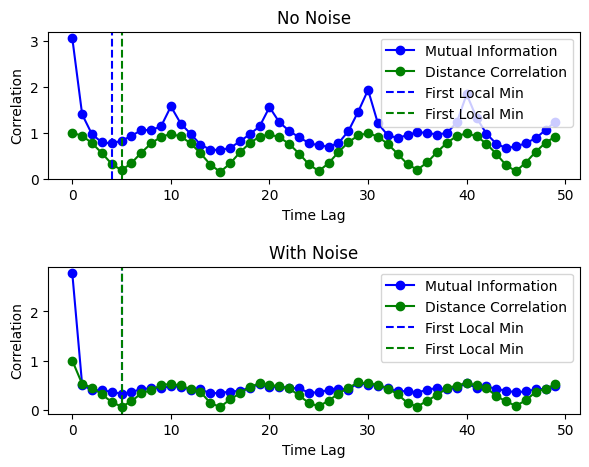

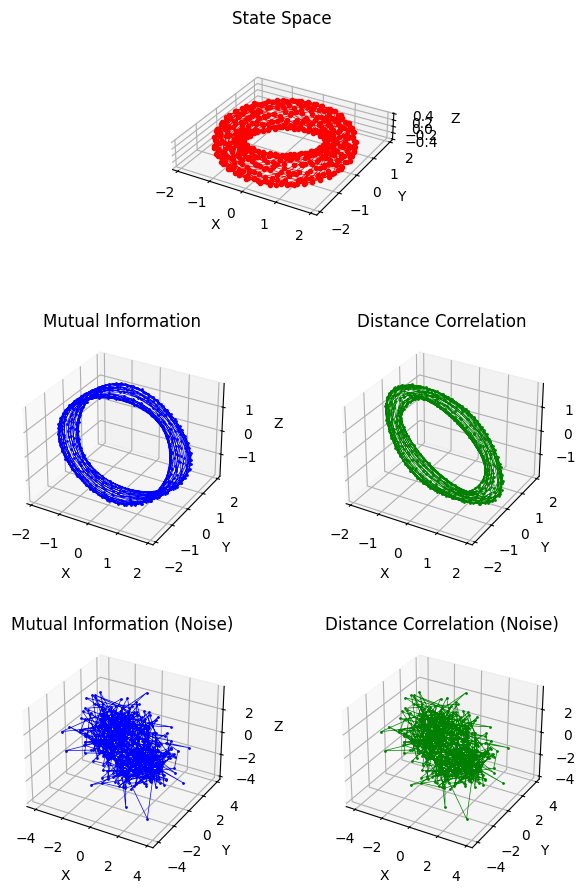

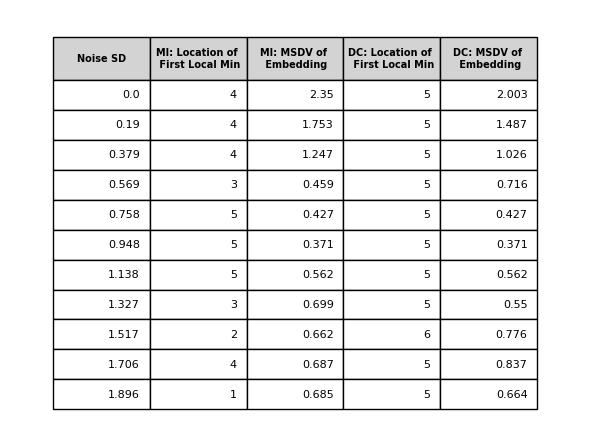

In [38]:
plots(statespace, X,"torus", dimension, max_lag, n_bins, order)

# Lorenz Attractor

In [46]:
def lorenz(t, y, sigma, rho, beta):
    dydt = [sigma * (y[1] - y[0]),
            y[0] * (rho - y[2]) - y[1],
            y[0] * y[1] - beta * y[2]]
    return dydt

# Set the parameters
sigma = 16.0
rho = 45.92
beta = 4.0

# Set the initial conditions
initial_conditions = [1.0, 0.0, 20.0]

# Set the time span for integration
t_span = (0, 50)
t_eval = np.linspace(t_span[0], t_span[1], 2000)

# Solve the system of differential equations
sol = solve_ivp(lorenz, t_span, initial_conditions, args=(sigma, rho, beta), t_eval=t_eval)
X = sol.y[0]
Y = sol.y[1]
Z = sol.y[2]
X = X[0:10000]
Y = Y[0:10000]
Z = Z[0:10000]
statespace = Q = np.stack((X, Y, Z), axis=1)

n_bins = int(math.sqrt(len(X)))
dimension = 3
max_lag = 50
order = 1

In [47]:
len(X)

2000

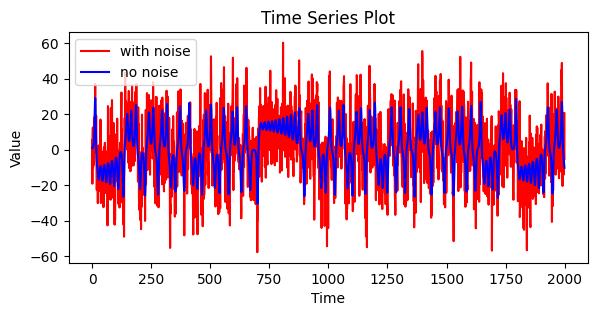

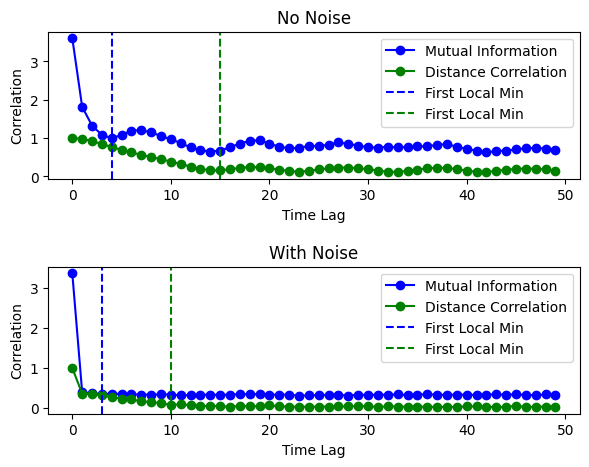

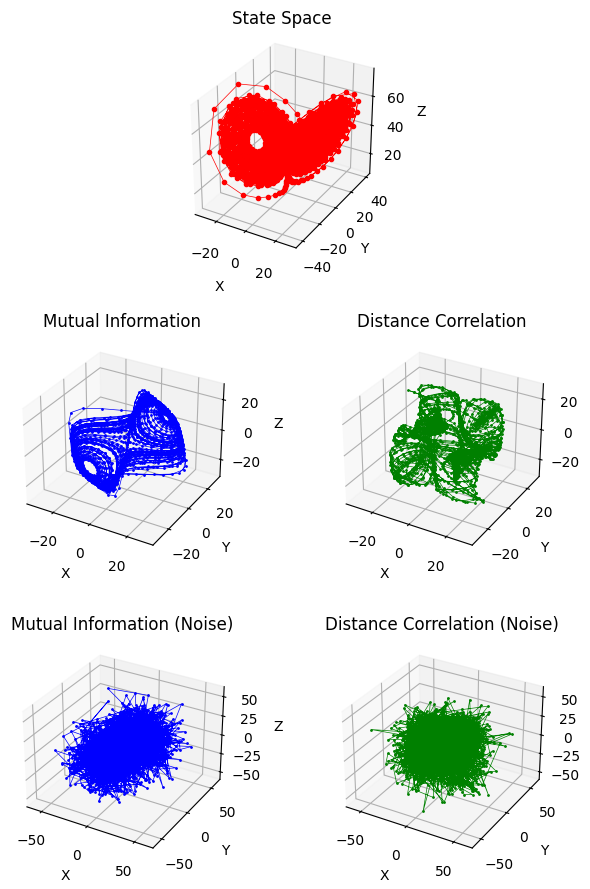

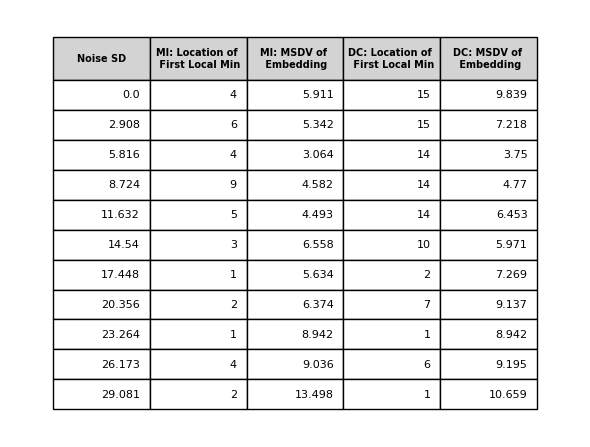

In [48]:
plots(statespace, X,"lorenz", dimension, max_lag, n_bins, order)

# Rossler Attractor

In [42]:
def rossler(t, y, a, b, c):
    dydt = [-y[1] - y[2],
            y[0] + a * y[1],
            b + y[2] * (y[0] - c)]
    return dydt

# Set the Rössler parameters
a = 0.2
b = 0.2
c = 5.7

# Set the initial conditions
initial_conditions = [0.0, 0.0, 0.0]

# Set the time span for integration
t_span = (0, 200)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solve the system of differential equations
sol = solve_ivp(rossler, t_span, initial_conditions, args=(a, b, c), t_eval=t_eval)
X = sol.y[0]
Y = sol.y[1]
Z = sol.y[2]
# X = X[0:2000]
# Y = Y[0:2000]
# Z = Z[0:2000]
statespace = Q = np.stack((X, Y, Z), axis=1)

n_bins = int(math.sqrt(len(X)))
dimension = 3
max_lag = 50
order = 1

In [43]:
len(X)

1000

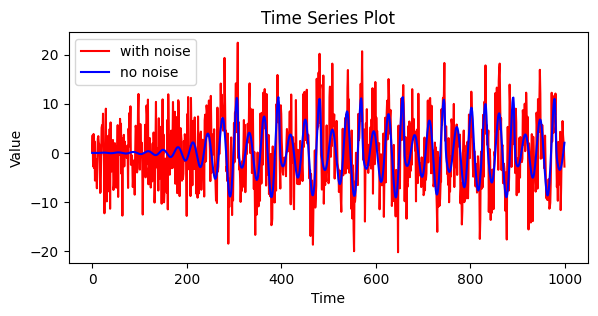

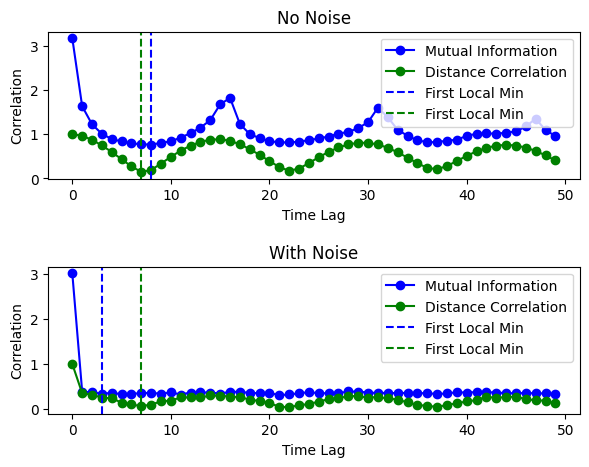

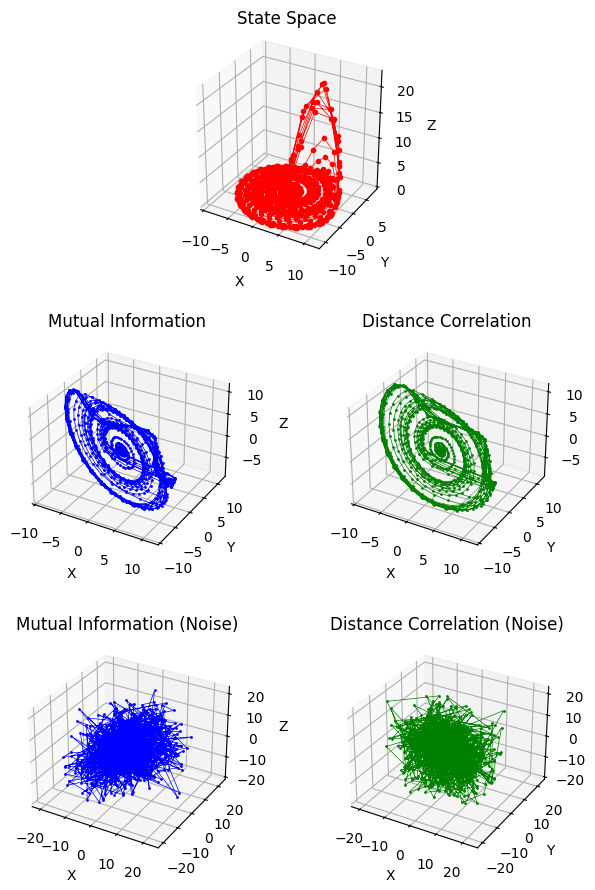

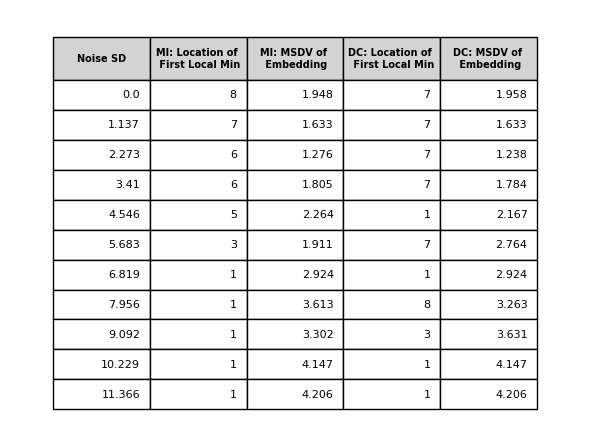

In [44]:
plots(statespace,X,"rossler", dimension, max_lag, n_bins, order)

# Ignore

In [49]:
!zip -r /content/file.zip /content

updating: content/ (stored 0%)
updating: content/.config/ (stored 0%)
updating: content/.config/active_config (stored 0%)
updating: content/.config/.last_opt_in_prompt.yaml (stored 0%)
updating: content/.config/config_sentinel (stored 0%)
updating: content/.config/.last_survey_prompt.yaml (stored 0%)
updating: content/.config/gce (stored 0%)
updating: content/.config/.last_update_check.json (deflated 23%)
updating: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
updating: content/.config/logs/ (stored 0%)
updating: content/.config/logs/2025.05.14/ (stored 0%)
updating: content/.config/logs/2025.05.14/13.38.05.736741.log (deflated 86%)
updating: content/.config/logs/2025.05.14/13.37.56.530848.log (deflated 58%)
updating: content/.config/logs/2025.05.14/13.38.07.566408.log (deflated 58%)
updating: content/.config/logs/2025.05.14/13.38.16.976468.log (deflated 57%)
updating: content/.config/logs/2025.05.14/13.38.17.706556.log (deflated 56%)
upd